<a href="https://colab.research.google.com/github/Riky2014/NAPDE/blob/main/sfere_sensitivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

In [1]:
%%capture
!pip install -U "monai-weekly[fire, nibabel, yaml, tqdm, einops]"

# Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import and set directory

In [10]:
import os
import time
import torch
import tempfile
import numpy as np
import nibabel as nib
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
from nibabel import load, save, Nifti1Image

import monai
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.utils import set_determinism
from monai.networks.nets import SegResNet
from monai.data import DataLoader, decollate_batch, create_test_image_3d

from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    LoadImaged,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)

directory_path = '/content/drive/MyDrive/sfere_sensitivity'
os.environ["MONAI_DATA_DIRECTORY"] = directory_path
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory

# Function definition

In [17]:
def create_image_3d(n_train, n_test, noise, r_min, r_max):

  for i in range(n_train + n_test):
    im, seg = create_test_image_3d(128, 128, 128, num_seg_classes = 1, noise_max = noise, rad_min = r_min, rad_max = r_max)
    n = nib.Nifti1Image(im, np.eye(4))
    nib.save(n, os.path.join(root_dir, f"image{i}.nii"))
    n = nib.Nifti1Image(seg, np.eye(4))
    nib.save(n, os.path.join(root_dir, f"label{i}.nii"))

  set_determinism(seed=0)

  images = sorted(glob(os.path.join(root_dir, "image*.nii")))
  labels = sorted(glob(os.path.join(root_dir, "label*.nii")))

  train_files = [{"image": image, "label": label} for image, label in zip(images[:n_train], labels[:n_train])]
  val_files = [{"image": image, "label": label} for image, label in zip(images[-n_test:], labels[-n_test:])]

  return train_files, val_files

In [5]:
def transform(train_files, val_files):
  train_transform = Compose([
      LoadImaged(keys=["image", "label"]),
      EnsureChannelFirstd(keys=["image","label"]),
      EnsureTyped(keys=["image", "label"]),
      Orientationd(keys=["image", "label"], axcodes="RAS"),
      Spacingd(
          keys=["image", "label"],
          pixdim=(1.0, 1.0, 1.0),
          mode=("bilinear", "nearest"),
      ),
      RandSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 128], random_size=False),
      RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
      RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
      RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
      NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
      RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
      RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
  ])

  val_transform = Compose([
      LoadImaged(keys=["image", "label"]),
      EnsureChannelFirstd(keys=["image","label"]),
      EnsureTyped(keys=["image", "label"]),
      Orientationd(keys=["image", "label"], axcodes="RAS"),
      Spacingd(
          keys=["image", "label"],
          pixdim=(1.0, 1.0, 1.0),
          mode=("bilinear", "nearest"),
      ),
      NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
  ])

  train_ds = monai.data.Dataset(data=train_files, transform=train_transform)
  train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2)

  val_ds = monai.data.Dataset(data=val_files, transform=val_transform)
  val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)

  return train_loader, val_loader, val_ds

In [6]:
def model_and_train(train_loader, val_loader, max_epochs, val_ds):
  val_interval = 1
  VAL_AMP = True

  device = torch.device("cuda:0")
  model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=1,
    out_channels=1,
    dropout_prob=0.2,
  ).to(device)

  loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
  optimizer = torch.optim.Adam(model.parameters(), 1e-3, weight_decay=1e-6)
  lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

  dice_metric = DiceMetric(include_background=True, reduction="mean")
  dice_metric_train = DiceMetric(include_background=True, reduction="mean")

  post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

  scaler = torch.cuda.amp.GradScaler()
  torch.backends.cudnn.benchmark = True

  epoch_loss_values = []
  metric_values = []
  metric_values_train = []
  total_start = time.time()

  for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = ( batch_data["image"].to(device), batch_data["label"].to(device) )
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)

        outputs = [post_trans(i) for i in decollate_batch(outputs)]

        dice_metric_train(y_pred=outputs, y=labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()

    metric_train = dice_metric_train.aggregate().item()
    metric_values_train.append(metric_train)
    dice_metric_train.reset()

    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"Loss: {epoch_loss:.4f} \nTrain dice: {metric_train:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (val_data["image"].to(device),val_data["label"].to(device))

                val_outputs = model(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]

                dice_metric(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            dice_metric.reset()

            print(f"Test dice: {metric:.4f}")

    print(f"Time: {(time.time() - epoch_start):.4f}")
  total_time = time.time() - total_start
  print(f"Train completed, total time: {total_time}.")
  print()
  print(f"Train metric = {metric_values_train[-1]}, Test metric = {metric_values[-1]}")
  print()
  print()

  model.eval()
  with torch.no_grad():
    i = 0

    val_input = val_ds[i]["image"].unsqueeze(0).to(device)

    val_outputs = model(val_input)
    val_outputs = post_trans(val_outputs[0])

    plt.figure("fig")
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

    ax1.set_title("Image")
    ax1.imshow(val_ds[i]["image"][0, :, :, 64].detach().cpu(), cmap="gray")

    ax2.set_title("Label")
    ax2.imshow(val_ds[i]["label"][0, :, :, 64].detach().cpu())

    ax3.set_title("Output")
    ax3.imshow(val_outputs[0, :, :, 64].detach().cpu())

    plt.show()

  return metric_values_train[-1], metric_values[-1], epoch_loss_values[-1]

In [7]:
def plot_graph(n_train_vec, metric_train, metric_test, loss, r_min, r_max, noise, max_epochs):
  fig, ax = plt.subplots(1, 2, figsize = (12,6))

  plt.subplot(1,2,1)
  plt.plot(n_train_vec, metric_train, label = 'Train metric')
  plt.plot(n_train_vec, metric_test, label = 'Test metric')

  plt.xscale('log', base = 2)
  plt.legend()
  plt.title(f"noise = {noise}, epochs = {max_epochs}, r = ({r_min}, {r_max})")

  plt.subplot(1,2,2)
  plt.plot(n_train_vec, loss, label = 'Train loss')
  plt.xscale('log', base = 2)
  plt.legend()
  plt.title(f"noise = {noise}, epochs = {max_epochs}, r = ({r_min}, {r_max})")

In [8]:
def delete_image(directory_path):
  file_list = os.listdir(directory_path)
  for file in file_list:
      file_path = os.path.join(directory_path, file)
      if os.path.isfile(file_path):
          os.remove(file_path)
      elif os.path.isdir(file_path):
          os.rmdir(file_path)
  print()

# Execute training
Specify:
- minimum radius ("r_min": int)
- maximum radius ("r_max": int)
- noise to be added ("noise": float)
- training epochs ("max_epochs": int)


Number of training images = 8
Number of testing images = 20

----------
epoch 1/25
Loss: 0.9584 
Train dice: 0.1930
Test dice: 0.1663
Time: 17.1922
----------
epoch 2/25
Loss: 0.9143 
Train dice: 0.2327
Test dice: 0.3254
Time: 12.5148
----------
epoch 3/25
Loss: 0.8830 
Train dice: 0.3845
Test dice: 0.4761
Time: 11.7760
----------
epoch 4/25
Loss: 0.8628 
Train dice: 0.5252
Test dice: 0.6613
Time: 12.0939
----------
epoch 5/25
Loss: 0.8457 
Train dice: 0.6543
Test dice: 0.7383
Time: 12.0364
----------
epoch 6/25
Loss: 0.8288 
Train dice: 0.7067
Test dice: 0.7543
Time: 11.7169
----------
epoch 7/25
Loss: 0.8101 
Train dice: 0.7525
Test dice: 0.7868
Time: 11.2067
----------
epoch 8/25
Loss: 0.7911 
Train dice: 0.7705
Test dice: 0.8236
Time: 11.5462
----------
epoch 9/25
Loss: 0.7726 
Train dice: 0.7895
Test dice: 0.8228
Time: 11.7076
----------
epoch 10/25
Loss: 0.7522 
Train dice: 0.8191
Test dice: 0.8124
Time: 11.9786
----------
epoch 11/25
Loss: 0.7316 
Train dice: 0.8271
Test dice: 

<Figure size 640x480 with 0 Axes>

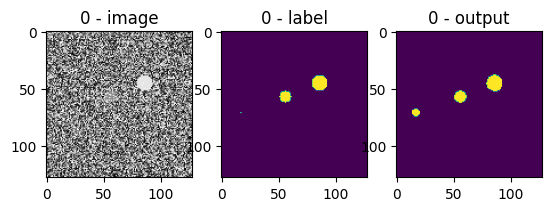



Number of training images = 16
Number of testing images = 20

----------
epoch 1/25
Loss: 0.9219 
Train dice: 0.2273
Test dice: 0.4523
Time: 15.9394
----------
epoch 2/25
Loss: 0.8602 
Train dice: 0.5973
Test dice: 0.7060
Time: 15.5230
----------
epoch 3/25
Loss: 0.8286 
Train dice: 0.7421
Test dice: 0.7799
Time: 15.5573
----------
epoch 4/25
Loss: 0.7924 
Train dice: 0.7827
Test dice: 0.8180
Time: 15.3528
----------
epoch 5/25
Loss: 0.7444 
Train dice: 0.8222
Test dice: 0.8367
Time: 15.3436
----------
epoch 6/25
Loss: 0.6765 
Train dice: 0.8507
Test dice: 0.8792
Time: 15.6095
----------
epoch 7/25
Loss: 0.5889 
Train dice: 0.8967
Test dice: 0.9131
Time: 16.9379
----------
epoch 8/25
Loss: 0.4937 
Train dice: 0.9202
Test dice: 0.9020
Time: 16.3864
----------
epoch 9/25
Loss: 0.4027 
Train dice: 0.9270
Test dice: 0.9391
Time: 15.3071
----------
epoch 10/25
Loss: 0.3217 
Train dice: 0.9396
Test dice: 0.9482
Time: 15.5555
----------
epoch 11/25
Loss: 0.2596 
Train dice: 0.9460
Test dice

<Figure size 640x480 with 0 Axes>

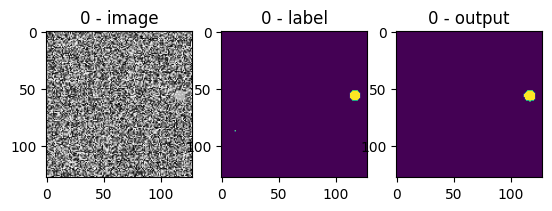



Number of training images = 32
Number of testing images = 20

----------
epoch 1/25
Loss: 0.8880 
Train dice: 0.4266
Test dice: 0.6833
Time: 22.8549
----------
epoch 2/25
Loss: 0.8079 
Train dice: 0.7699
Test dice: 0.8480
Time: 22.3710
----------
epoch 3/25
Loss: 0.7013 
Train dice: 0.8523
Test dice: 0.8912
Time: 21.1565
----------
epoch 4/25
Loss: 0.5116 
Train dice: 0.9134
Test dice: 0.9438
Time: 21.9338
----------
epoch 5/25
Loss: 0.3014 
Train dice: 0.9423
Test dice: 0.9386
Time: 21.8498
----------
epoch 6/25
Loss: 0.1704 
Train dice: 0.9524
Test dice: 0.9669
Time: 21.0239
----------
epoch 7/25
Loss: 0.1083 
Train dice: 0.9613
Test dice: 0.9671
Time: 21.9628
----------
epoch 8/25
Loss: 0.0787 
Train dice: 0.9657
Test dice: 0.9698
Time: 21.0920
----------
epoch 9/25
Loss: 0.0643 
Train dice: 0.9658
Test dice: 0.9657
Time: 22.8699
----------
epoch 10/25
Loss: 0.0535 
Train dice: 0.9696
Test dice: 0.9705
Time: 21.7203
----------
epoch 11/25
Loss: 0.0486 
Train dice: 0.9685
Test dice

<Figure size 640x480 with 0 Axes>

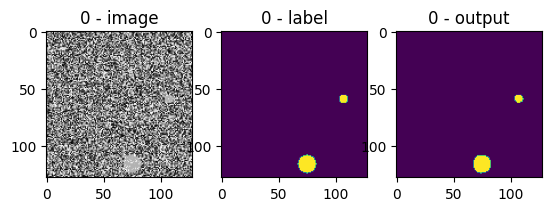

In [18]:
n_train_vec  = [8, 16, 32]
n_test = 20

noise = 1
r_min = 5
r_max = 10

max_epochs = 25

metric_values_train_vec = []
metric_values_vec = []
epoch_loss_values_vec = []


for n_train in n_train_vec:
  print()
  print(f"Number of training images = {n_train}")
  print(f"Number of testing images = {n_test}")
  print()

  train_files, val_files = create_image_3d(n_train, n_test, noise, r_min, r_max)
  train_loader, val_loader, val_ds = transform(train_files, val_files)

  metric_value_train, metric_value, epoch_loss_value = model_and_train(train_loader, val_loader, max_epochs, val_ds)

  metric_values_train_vec.append(metric_value_train)
  metric_values_vec.append(metric_value)
  epoch_loss_values_vec.append(epoch_loss_value)

  delete_image(directory_path)

# Plot train and test metrics

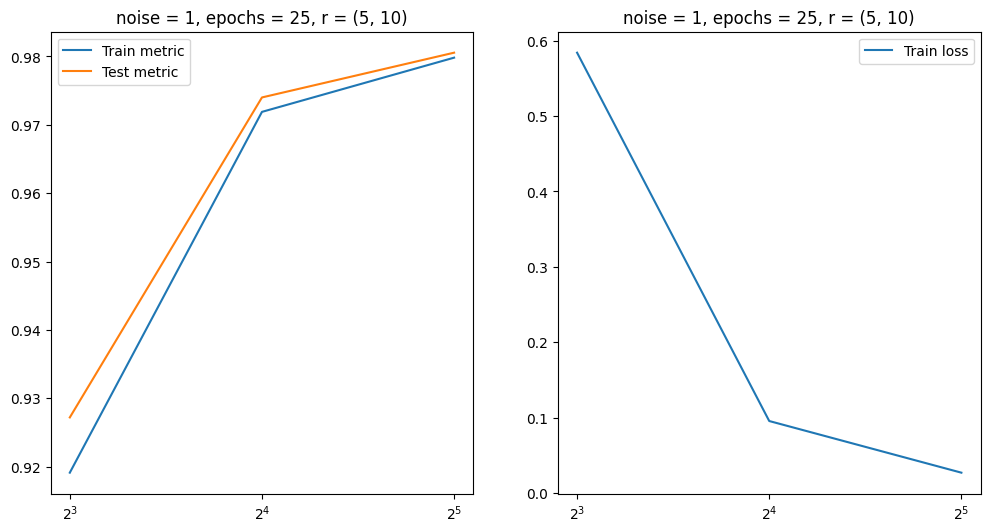

In [19]:
plot_graph(n_train_vec, metric_values_train_vec, metric_values_vec, epoch_loss_values_vec, r_min, r_max, noise, max_epochs)